In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
# out_dir = "out-enwiki-char"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_16094/1980074258.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


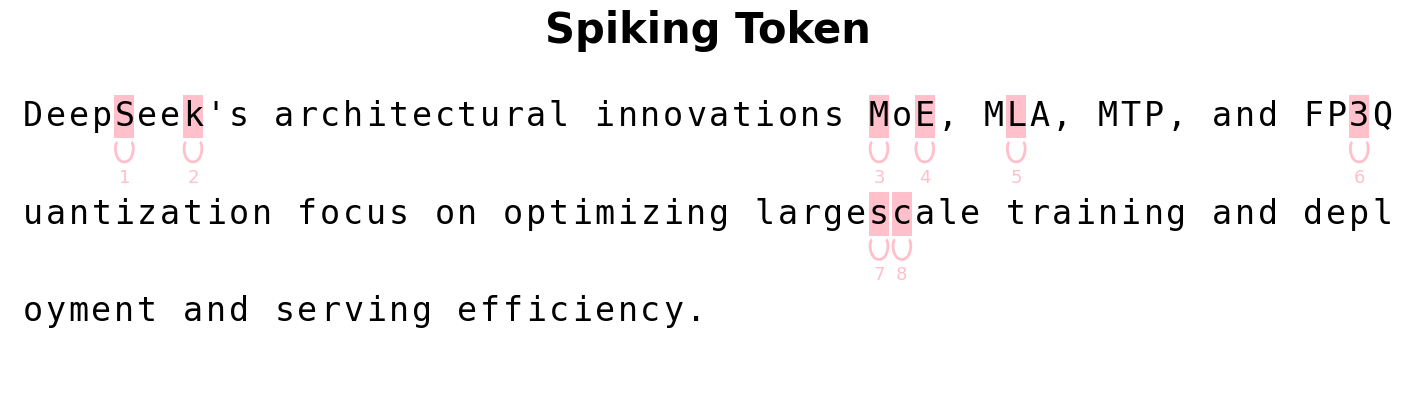

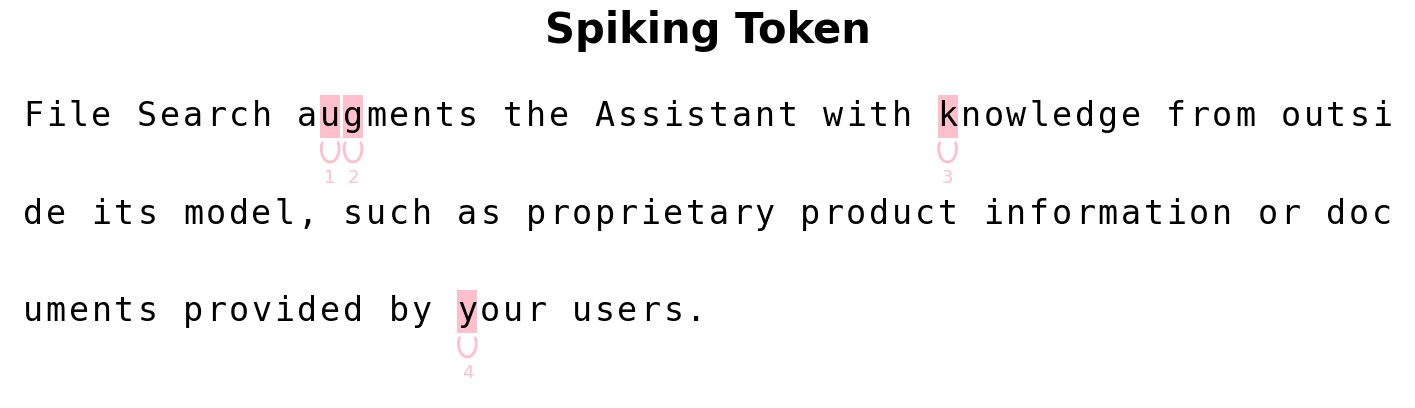

   :: Remove token mask calculation: 0.0005 seconds
   :: Remove token list appending loop: 0.0001 seconds
   :: Remove token group appending loop: 0.0000 seconds


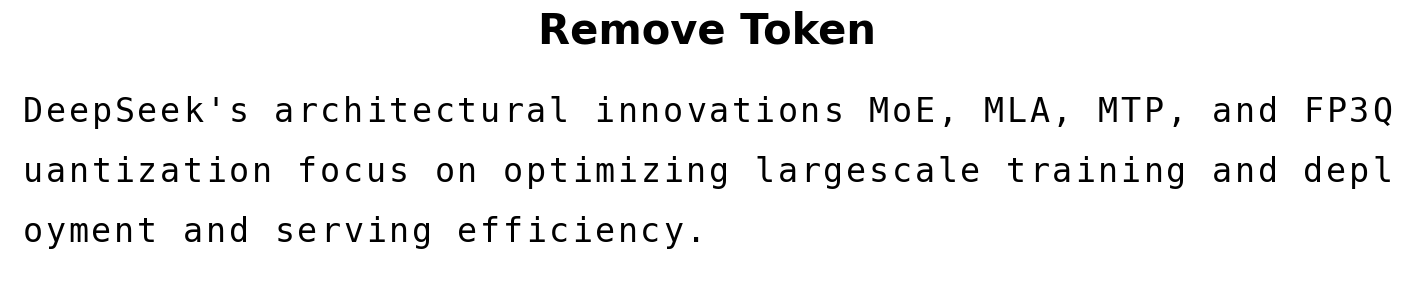

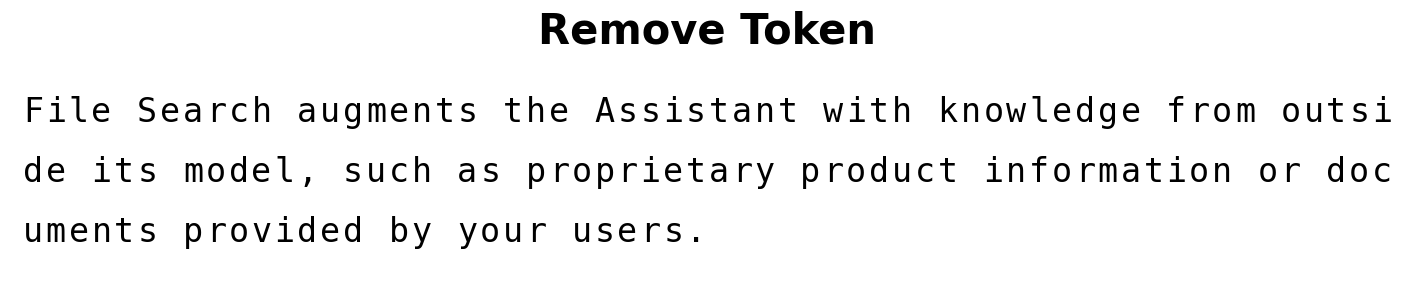

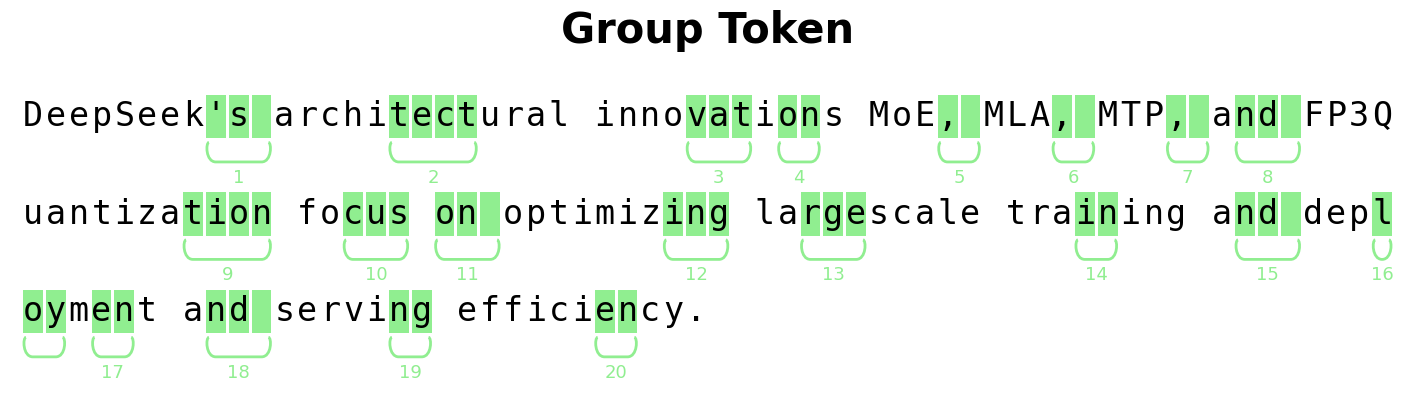

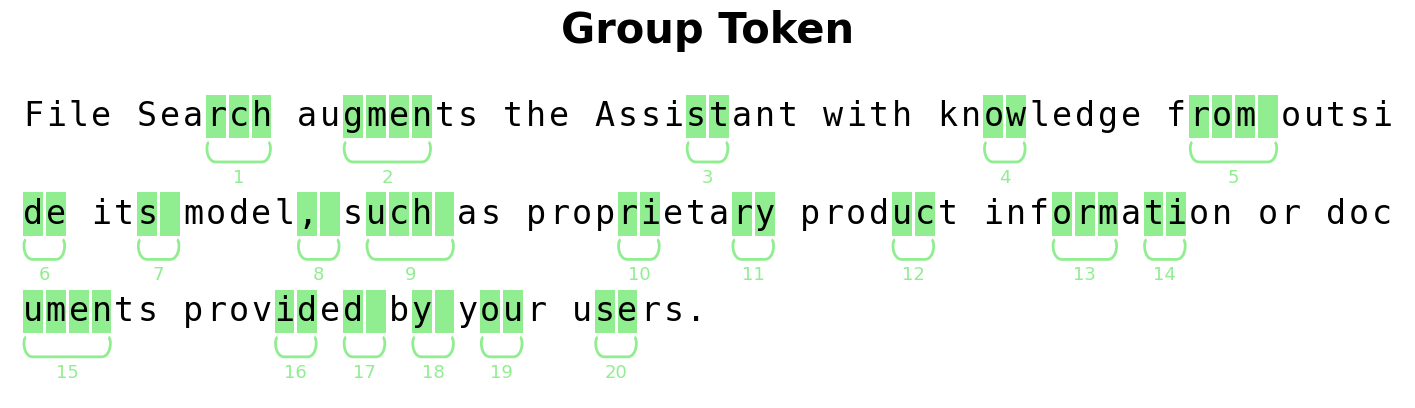

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.2)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [4]:
from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
from magicab.magicab import get_batch
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
# t0 = time.time()
# prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
# t1 = time.time()
# print("Time taken to update data: ", t1 - t0)

In [ ]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"
max_size_change = 2000

update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change)

Updating Magicab Vocabulary:   0%|          | 0/763 [00:00<?, ?it/s]

 - Inference took: 1.0516 seconds
   :: Remove token mask calculation: 0.1158 seconds
   :: Remove token list appending loop: 0.0516 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1675 seconds
 - Group token detection took: 0.2922 seconds
   :: add_tokens: 0.0120 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1086 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0041 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0735 seconds
   :: update_caches: per input row  0.0003 seconds
 - Vocabulary addition prep took: 0.1994 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0030 seconds


Updating Magicab Vocabulary:   0%|          | 1/763 [00:01<21:51,  1.72s/it]

Function _cache_vocabulary_change took 1.7148 seconds
 - Inference took: 0.9185 seconds
   :: Remove token mask calculation: 0.0726 seconds
   :: Remove token list appending loop: 0.0544 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1271 seconds


Updating Magicab Vocabulary:   0%|          | 2/763 [00:03<20:11,  1.59s/it]

 - Group token detection took: 0.2938 seconds
   :: add_tokens: 0.0119 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1063 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0040 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0157 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1390 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0183 seconds
Function _cache_vocabulary_change took 1.4978 seconds
 - Inference took: 0.9090 seconds
   :: Remove token mask calculation: 0.0618 seconds
   :: Remove token list appending loop: 0.0510 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1129 seconds


Updating Magicab Vocabulary:   0%|          | 3/763 [00:04<19:48,  1.56s/it]

 - Group token detection took: 0.3502 seconds
   :: add_tokens: 0.0126 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1064 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0043 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0158 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1403 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.5256 seconds
 - Inference took: 0.9177 seconds
   :: Remove token mask calculation: 0.0669 seconds
   :: Remove token list appending loop: 0.0523 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1193 seconds


Updating Magicab Vocabulary:   1%|          | 4/763 [00:06<19:20,  1.53s/it]

 - Group token detection took: 0.2906 seconds
   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1031 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0038 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0141 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1333 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0124 seconds
Function _cache_vocabulary_change took 1.4742 seconds
 - Inference took: 0.9098 seconds
   :: Remove token mask calculation: 0.0763 seconds
   :: Remove token list appending loop: 0.0545 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1309 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [00:07<19:25,  1.54s/it]

 - Group token detection took: 0.3569 seconds
   :: add_tokens: 0.0122 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1043 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0043 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0151 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1369 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.5479 seconds
 - Inference took: 0.9095 seconds
   :: Remove token mask calculation: 0.0575 seconds
   :: Remove token list appending loop: 0.0536 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1112 seconds


Updating Magicab Vocabulary:   1%|          | 6/763 [00:09<19:09,  1.52s/it]

 - Group token detection took: 0.2988 seconds
   :: add_tokens: 0.0127 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1103 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0042 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0164 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1447 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.4776 seconds
 - Inference took: 0.9121 seconds
   :: Remove token mask calculation: 0.0636 seconds
   :: Remove token list appending loop: 0.0518 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1156 seconds


Updating Magicab Vocabulary:   1%|          | 7/763 [00:10<19:18,  1.53s/it]

 - Group token detection took: 0.3701 seconds
   :: add_tokens: 0.0131 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1119 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0044 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0165 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1470 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0129 seconds
Function _cache_vocabulary_change took 1.5589 seconds
 - Inference took: 0.9160 seconds
   :: Remove token mask calculation: 0.0683 seconds
   :: Remove token list appending loop: 0.0546 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1231 seconds


Updating Magicab Vocabulary:   1%|          | 8/763 [00:12<19:07,  1.52s/it]

 - Group token detection took: 0.2958 seconds
   :: add_tokens: 0.0118 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1073 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0039 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0151 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1391 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.4871 seconds
 - Inference took: 0.9145 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds


Updating Magicab Vocabulary:   1%|          | 9/763 [00:13<18:53,  1.50s/it]

 - Group token detection took: 0.2904 seconds
   :: add_tokens: 0.0120 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1055 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0044 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0147 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1377 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0131 seconds
Function _cache_vocabulary_change took 1.4636 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0582 seconds
   :: Remove token list appending loop: 0.0527 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1109 seconds


Updating Magicab Vocabulary:   1%|▏         | 10/763 [00:15<19:02,  1.52s/it]

 - Group token detection took: 0.3745 seconds
   :: add_tokens: 0.0124 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1065 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0042 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0161 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1403 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.5439 seconds
 - Inference took: 0.9087 seconds
   :: Remove token mask calculation: 0.0763 seconds
   :: Remove token list appending loop: 0.0545 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1309 seconds


Updating Magicab Vocabulary:   1%|▏         | 11/763 [00:16<18:54,  1.51s/it]

 - Group token detection took: 0.2942 seconds
   :: add_tokens: 0.0122 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1069 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0044 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0152 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1397 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0129 seconds
Function _cache_vocabulary_change took 1.4877 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0586 seconds
   :: Remove token list appending loop: 0.0518 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1105 seconds


Updating Magicab Vocabulary:   2%|▏         | 12/763 [00:18<18:43,  1.50s/it]

 - Group token detection took: 0.2940 seconds
   :: add_tokens: 0.0123 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1062 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0039 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0149 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1384 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0123 seconds
Function _cache_vocabulary_change took 1.4624 seconds
 - Inference took: 0.9043 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0517 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1074 seconds


Updating Magicab Vocabulary:   2%|▏         | 13/763 [00:19<18:56,  1.51s/it]

 - Group token detection took: 0.3906 seconds
   :: add_tokens: 0.0121 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1063 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0045 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0144 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1385 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0132 seconds
Function _cache_vocabulary_change took 1.5551 seconds
 - Inference took: 0.9078 seconds
   :: Remove token mask calculation: 0.0575 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1083 seconds


Updating Magicab Vocabulary:   2%|▏         | 14/763 [00:21<18:46,  1.50s/it]

 - Group token detection took: 0.2973 seconds
   :: add_tokens: 0.0128 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1117 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0044 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0173 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1473 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0130 seconds
Function _cache_vocabulary_change took 1.4747 seconds
 - Inference took: 0.9222 seconds
   :: Remove token mask calculation: 0.0668 seconds
   :: Remove token list appending loop: 0.0516 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1184 seconds


Updating Magicab Vocabulary:   2%|▏         | 15/763 [00:22<18:44,  1.50s/it]

 - Group token detection took: 0.2996 seconds
   :: add_tokens: 0.0124 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1089 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0042 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0155 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1421 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0154 seconds
Function _cache_vocabulary_change took 1.4989 seconds
 - Inference took: 0.9193 seconds
   :: Remove token mask calculation: 0.0607 seconds
   :: Remove token list appending loop: 0.0548 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1156 seconds
 - Group token detection took: 0.2980 seconds


Updating Magicab Vocabulary:   2%|▏         | 16/763 [00:24<19:06,  1.53s/it]

   :: add_tokens: 0.0123 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1160 seconds
   :: slice_embeddings: per input row  0.0005 seconds
   :: update_token_addition: 0.1124 seconds
   :: update_token_addition: per input row  0.0004 seconds
   :: update_caches: 0.0151 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.2569 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.6029 seconds
 - Inference took: 0.9304 seconds
   :: Remove token mask calculation: 0.0614 seconds
   :: Remove token list appending loop: 0.0532 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1147 seconds


Updating Magicab Vocabulary:   2%|▏         | 17/763 [00:25<18:58,  1.53s/it]

 - Group token detection took: 0.2995 seconds
   :: add_tokens: 0.0126 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1085 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0043 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0170 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1435 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0134 seconds
Function _cache_vocabulary_change took 1.5027 seconds
 - Inference took: 0.9238 seconds
   :: Remove token mask calculation: 0.0583 seconds
   :: Remove token list appending loop: 0.0539 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1123 seconds


Updating Magicab Vocabulary:   2%|▏         | 18/763 [00:27<18:51,  1.52s/it]

 - Group token detection took: 0.3003 seconds
   :: add_tokens: 0.0134 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1118 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0047 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0175 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1485 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0137 seconds
Function _cache_vocabulary_change took 1.5000 seconds
 - Inference took: 0.9175 seconds
   :: Remove token mask calculation: 0.0596 seconds
   :: Remove token list appending loop: 0.0520 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1116 seconds


Updating Magicab Vocabulary:   2%|▏         | 19/763 [00:28<18:44,  1.51s/it]

 - Group token detection took: 0.2977 seconds
   :: add_tokens: 0.0127 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1136 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0042 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0170 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1486 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0125 seconds
Function _cache_vocabulary_change took 1.4892 seconds
 - Inference took: 0.9193 seconds
   :: Remove token mask calculation: 0.0674 seconds
   :: Remove token list appending loop: 0.0520 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1195 seconds
 - Group token detection took: 0.2954 seconds


Updating Magicab Vocabulary:   3%|▎         | 20/763 [00:30<19:06,  1.54s/it]

   :: add_tokens: 0.0129 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1074 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0043 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.1370 seconds
   :: update_caches: per input row  0.0005 seconds
 - Vocabulary addition prep took: 0.2628 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0129 seconds
Function _cache_vocabulary_change took 1.6114 seconds
 - Inference took: 0.9082 seconds
   :: Remove token mask calculation: 0.0613 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1136 seconds


Updating Magicab Vocabulary:   3%|▎         | 21/763 [00:32<18:48,  1.52s/it]

 - Group token detection took: 0.2945 seconds
   :: add_tokens: 0.0122 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1021 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0038 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0147 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1339 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0138 seconds
Function _cache_vocabulary_change took 1.4654 seconds
 - Inference took: 0.9083 seconds
   :: Remove token mask calculation: 0.0687 seconds
   :: Remove token list appending loop: 0.0526 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1215 seconds
 - Group token detection took: 0.2879 seconds


Updating Magicab Vocabulary:   3%|▎         | 22/763 [00:33<19:16,  1.56s/it]

   :: add_tokens: 0.0282 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.2195 seconds
   :: slice_embeddings: per input row  0.0009 seconds
   :: update_token_addition: 0.0098 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0460 seconds
   :: update_caches: per input row  0.0002 seconds
 - Vocabulary addition prep took: 0.3063 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0267 seconds
Function _cache_vocabulary_change took 1.6519 seconds
 - Inference took: 0.9233 seconds
   :: Remove token mask calculation: 0.0590 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1114 seconds


Updating Magicab Vocabulary:   3%|▎         | 23/763 [00:35<18:57,  1.54s/it]

 - Group token detection took: 0.2944 seconds
   :: add_tokens: 0.0120 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1016 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0041 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0157 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1344 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0134 seconds
Function _cache_vocabulary_change took 1.4779 seconds
 - Inference took: 0.9221 seconds
   :: Remove token mask calculation: 0.0628 seconds
   :: Remove token list appending loop: 0.0542 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1171 seconds


Updating Magicab Vocabulary:   3%|▎         | 24/763 [00:36<18:51,  1.53s/it]

 - Group token detection took: 0.3092 seconds
   :: add_tokens: 0.0129 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1115 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0043 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0181 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1480 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0139 seconds
Function _cache_vocabulary_change took 1.5115 seconds


In [4]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"

x,y = get_batch('train', data_dir, block_size, batch_size, device_type, device)

In [5]:
magicab.cache_vocab_change(input_ids=x, target_ids=y, avoid_duplicate=False, cal_mask_device="mps")

 - Inference took: 1.0606 seconds
   :: Remove token mask calculation: 0.1252 seconds
   :: Remove token list appending loop: 0.0523 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1776 seconds
 - Group token detection took: 0.2949 seconds
   :: add_tokens: 0.0359 seconds
   :: slice_embeddings: 0.1108 seconds
   :: update_token_addition: 0.0041 seconds
   :: update_caches: 0.0186 seconds
 - Vocabulary addition prep took: 0.1705 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0028 seconds
Function _cache_vocabulary_change took 1.7075 seconds
